#  Построение модели определения стоимости автомобиля

Задача проекта: разработка системы рекомендации стоимости автомобиля на основе его описания.

Сервис по продаже автомобилей с пробегом  разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. На основе исторические данные необходимо построить модель для определения стоимости автомобиля.

Заказчику важны:

- качество предсказания, критерий успеха RMSE до 2500;
- скорость предсказания;
- время обучения.

Инструменты: градиентный бустинг, регрессия.

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import os
from time import time

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor, Pool, cv
import lightgbm as lgb
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
def plot_features(data):   
    sns.set_theme()
    
    num_data = data.select_dtypes(include=['float64', 'int64'])
    count_num_features = len(num_data.columns)
    fig, axes = plt.subplots(nrows=count_num_features, ncols=2, figsize=(18, 14))
    
    if count_num_features > 1:
        for i, column in enumerate(num_data.columns):
            sns.histplot(num_data[column], ax=axes[i, 0], bins=20) 
            axes[i, 0].set_title(f'Гистограмма {column}')
            
            sns.boxplot(num_data[column], ax=axes[i, 1],  width=.8)
            axes[i, 1].set_title(f'Ящик с усами {column}')
    elif count_num_features == 1:
        for column in num_data.columns:
            sns.histplot(num_data[column], ax=axes[0], bins=20) 
            axes[0].set_title(f'Гистограмма {column}')
            
            sns.boxplot(x=num_data[column], ax=axes[1],  width=.8)
            axes[1].set_title(f'Ящик с усами {column}')
            
    plt.tight_layout()
    plt.show()

In [5]:
df = pd.read_csv(pth_rmt, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Изучим данные.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

<Axes: >

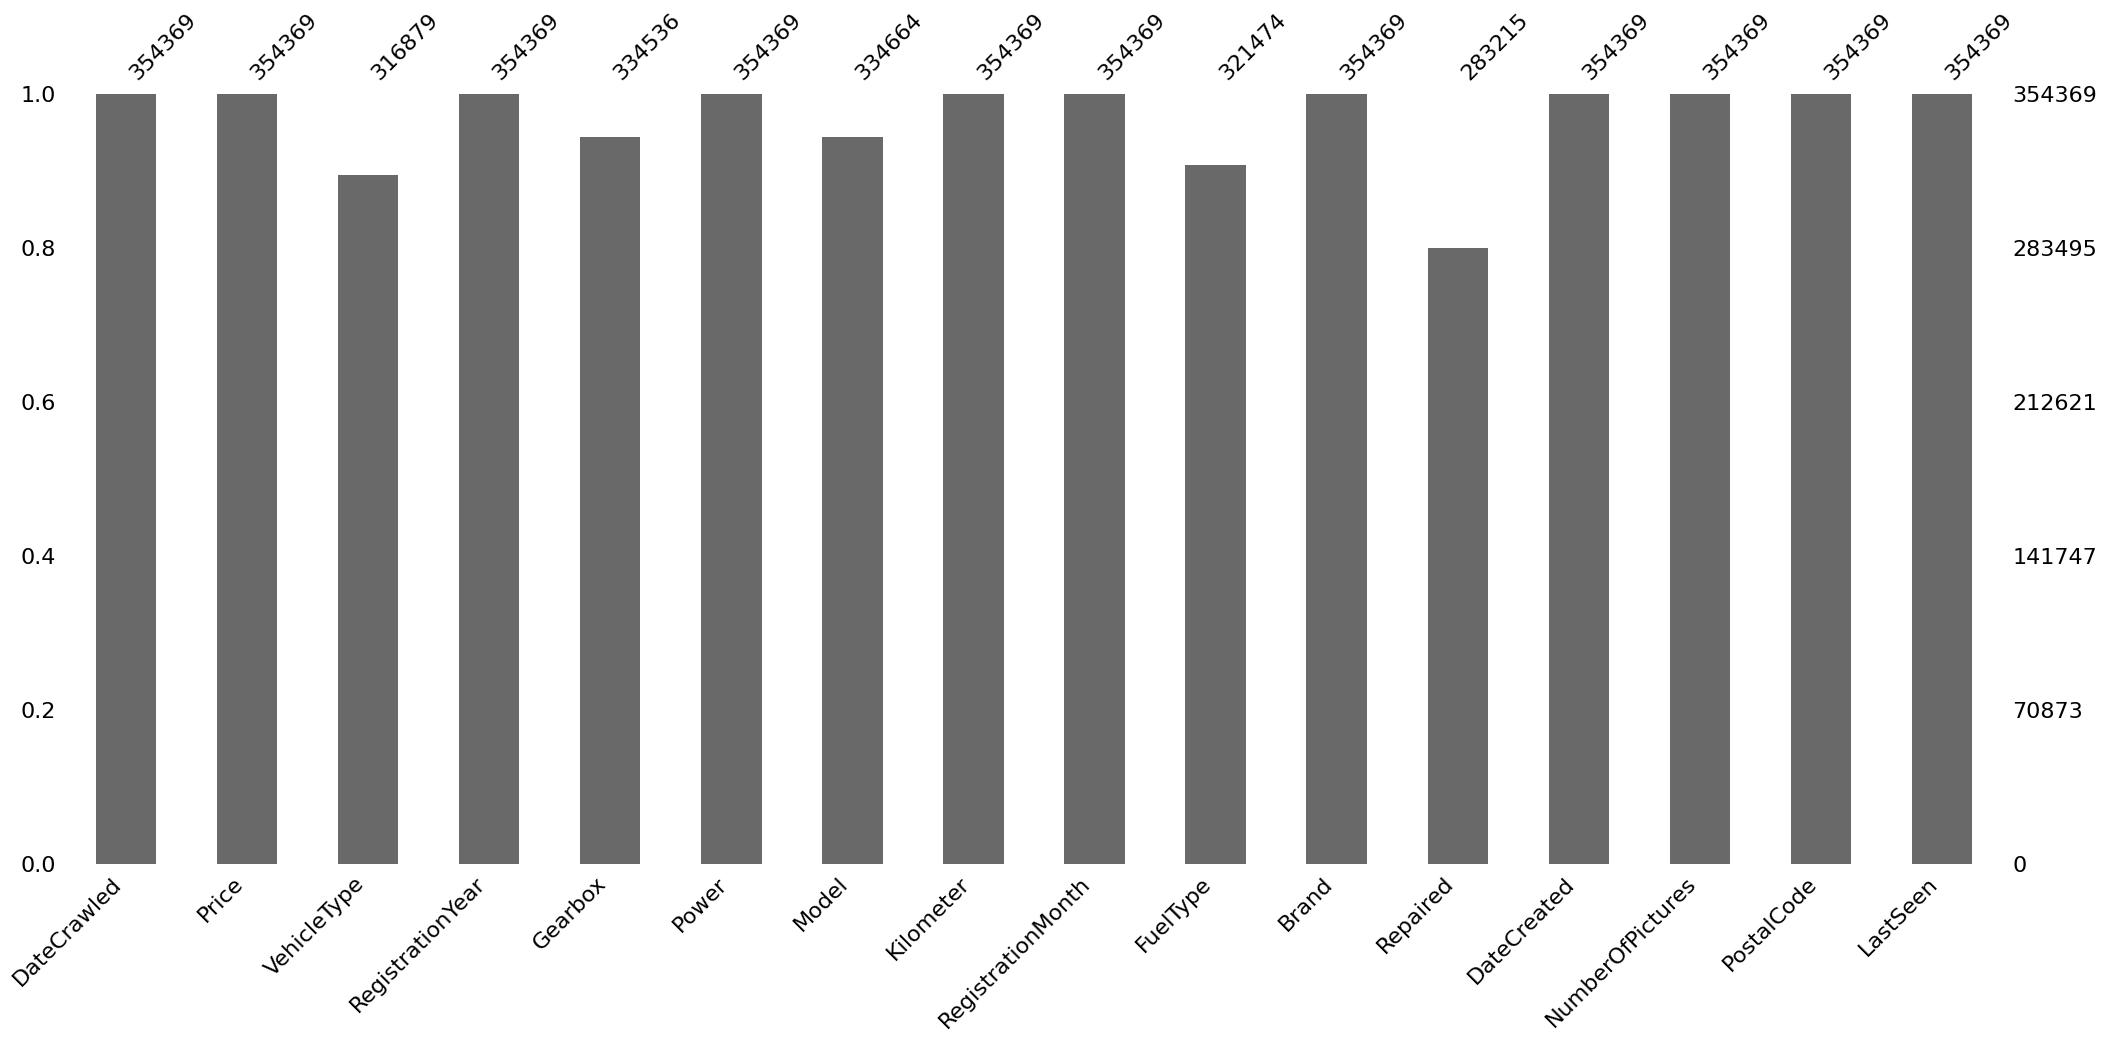

In [8]:
msno.bar(df)

В данных 354369 строки. Наблюдаем пропущенные значения в столбцах VehicleType, Gearbox, Model, FuelType, и Repaired. Обработаем пропуски в пайплайне.

Среди данных имеются неинформативные признаки, которые не влияют на оценку авто, а именно: DateCrawled, RegistrationMonth, DateCreated, LastSeen, PostalCode. Признак количества фотографий NumberOfPictures может влиять на привлекательность конкретного объявления, но вряд ли влияет на рыночною стоимость автомобиля, исключим и его. Если предположить, что LastSeen является датой продажи авто, а цена сильно зависит от года, оставим это поле.

In [9]:
df_filtered = df.drop(columns=['DateCrawled', 'RegistrationMonth', 'PostalCode', 'LastSeen', 'NumberOfPictures'])

Далее удалим из данных все нереалистичные строки, например, Price равный 0. Также не представляется возможным, чтобы значение цены равнялось 2 или 3 евро. Установим порог в 1000 евро.

In [10]:
df_filtered =  df_filtered.loc[df['Price'] >= 1000]

In [11]:
df_filtered.describe()

,Price,RegistrationYear,Power,Kilometer,DateCreated
count,271043.000000,271043.000000,271043.000000,271043.000000,271043
mean,5619.382821,2004.733884,121.386293,125903.897168,2016-03-20 20:05:36.885291520
min,1000.000000,1000.000000,0.000000,5000.000000,2014-03-10 00:00:00
25%,2100.000000,2001.000000,75.000000,100000.000000,2016-03-13 00:00:00
50%,3999.000000,2005.000000,116.000000,150000.000000,2016-03-21 00:00:00
75%,7900.000000,2008.000000,150.000000,150000.000000,2016-03-29 00:00:00
max,20000.000000,9999.000000,20000.000000,150000.000000,2016-04-07 00:00:00
std,4523.201334,58.215455,192.773496,38257.406600,NaN


Год регистрации имеет разброс от 1000 до 9999. По верхней границе год регистрации нужно синхронизировать с датой выгрузки данных из базы: в таблице не может быть объявлений моложе даты выгрузки, иначе это были бы просто данные из будущего. Ограничим год реалистичными значениями.

In [12]:
df_filtered = df_filtered.loc[df_filtered['RegistrationYear'] >= 1985] 
df_filtered = df_filtered.loc[df_filtered['RegistrationYear'] <= df_filtered['DateCreated'].dt.year]
df_filtered = df_filtered.drop(columns='DateCreated')

В поле Power присутствует большое количество нулей и аномально высоких значений. Для удобства удалим аномалии. Не будем заполнять мощность модой по модели, так как в поле Model имеются пропуски, что усложняет процесс нахождения истинной мощности авто.

In [13]:
df_filtered = df_filtered.loc[(df_filtered['Power'] >= 40) & (df_filtered['Power'] <= 300)] 

Для определения цены автомобиля важно знать ее модель, она имеет высокую корреляцию с ценой. Первый вариант использовать заглушку со значением `other`. Но бизнес может поставить принудительное ограничение на ввод пользователем модели авто в объявлении. Удалим данные с пропусками в этом поле.

In [14]:
df_filtered = df_filtered.dropna(subset=['Model'])
df_filtered = df_filtered[df_filtered['Model'] != 'other']

Перед заполнением пропусков разделим данные на тренировочную и тестовую выборки.

In [15]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(df_filtered.drop(columns='Price'),
                                                    df_filtered['Price'],
                                                    test_size=TEST_SIZE,
                                                    random_state= RANDOM_STATE,
                                                    stratify=df_filtered['Brand'])

Объединим признаки в один датафрейм.

In [16]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

Предположим, что пропуски в Repaired означают `no`.

In [17]:
df_train['Repaired'] = df_train['Repaired'].fillna('no')

In [18]:
print(df_train.shape)
df_train.isna().sum()

(170895, 10)


VehicleType         3842
RegistrationYear       0
Gearbox             2286
Power                  0
Model                  0
Kilometer              0
FuelType            5812
Brand                  0
Repaired               0
Price                  0
dtype: int64

Сгруппируем данные по модели и заполним VehicleType модой.  

In [19]:
df_train['VehicleType'] = df_train.groupby('Model')['VehicleType'].transform(
        lambda x: x.fillna((x.mode()[0] if x.count()!=0 else "other")))

Аналогично поступим с оставшимися пропущенными значениями в Gearbox и FuelType.

In [20]:
for col in ['Gearbox', 'FuelType']:
        df_train[col] = df_train.groupby('Model')[col].transform(
                lambda x: x.fillna((x.mode()[0] if x.count()!=0 else "other")))

### Исследовательский анализ

Рассмотрим графики по численным признакам.

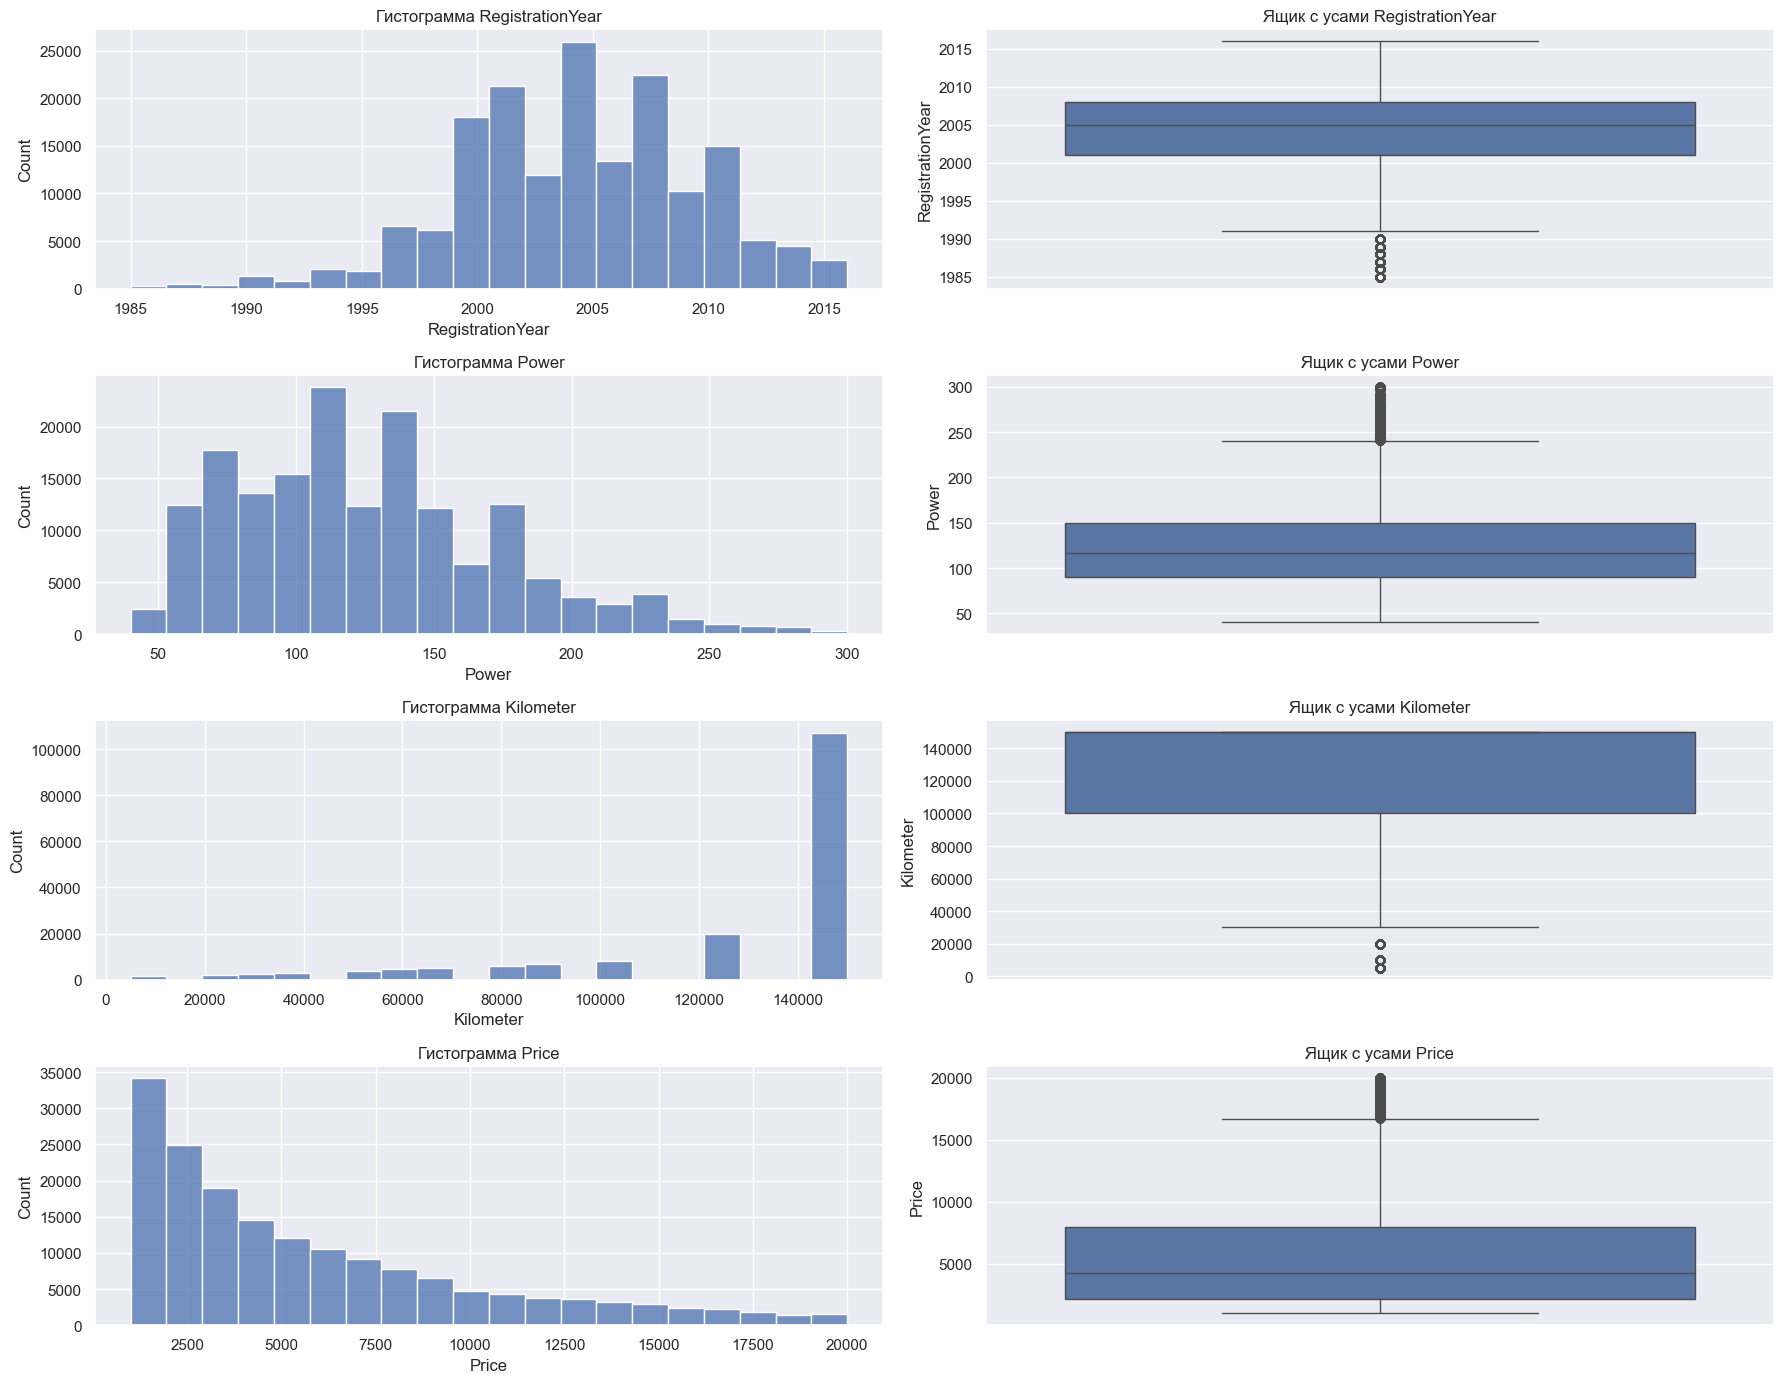

In [21]:
plot_features(df_train)

Price имеет скошенное влево распределение. Медианная стоимость составляет 2950 евро. RegistrationYear имеет нормальное распределение. Километраж в основном принимает значения 130 - 150 тыс км.

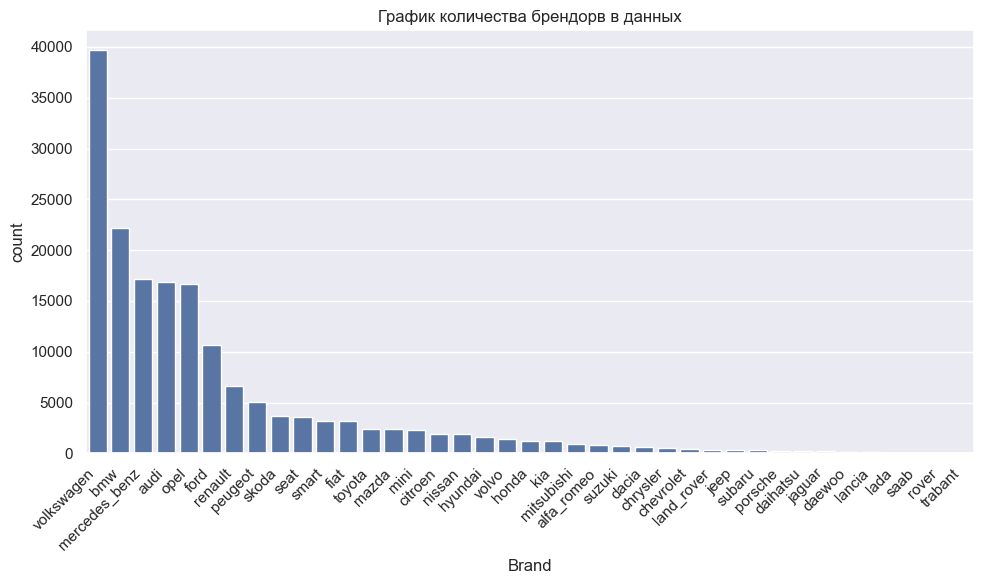

In [22]:
plt.figure(figsize=(10,6))

brand_plot = sns.countplot(x='Brand', data=df_train,  order=df_train.Brand.value_counts().index)
brand_plot.set_xticklabels(brand_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('График количества брендорв в данных')
plt.tight_layout()
plt.show()

Наблюдается дисбаланс классов по количеству брендов, при разбиении выборки на тренировочную и тестовую возможно будет полезно применить стратификацию по признаку Brand.

Изучим корреляцию между признаками.

In [23]:
interval_cols = ['Power', 'Price']

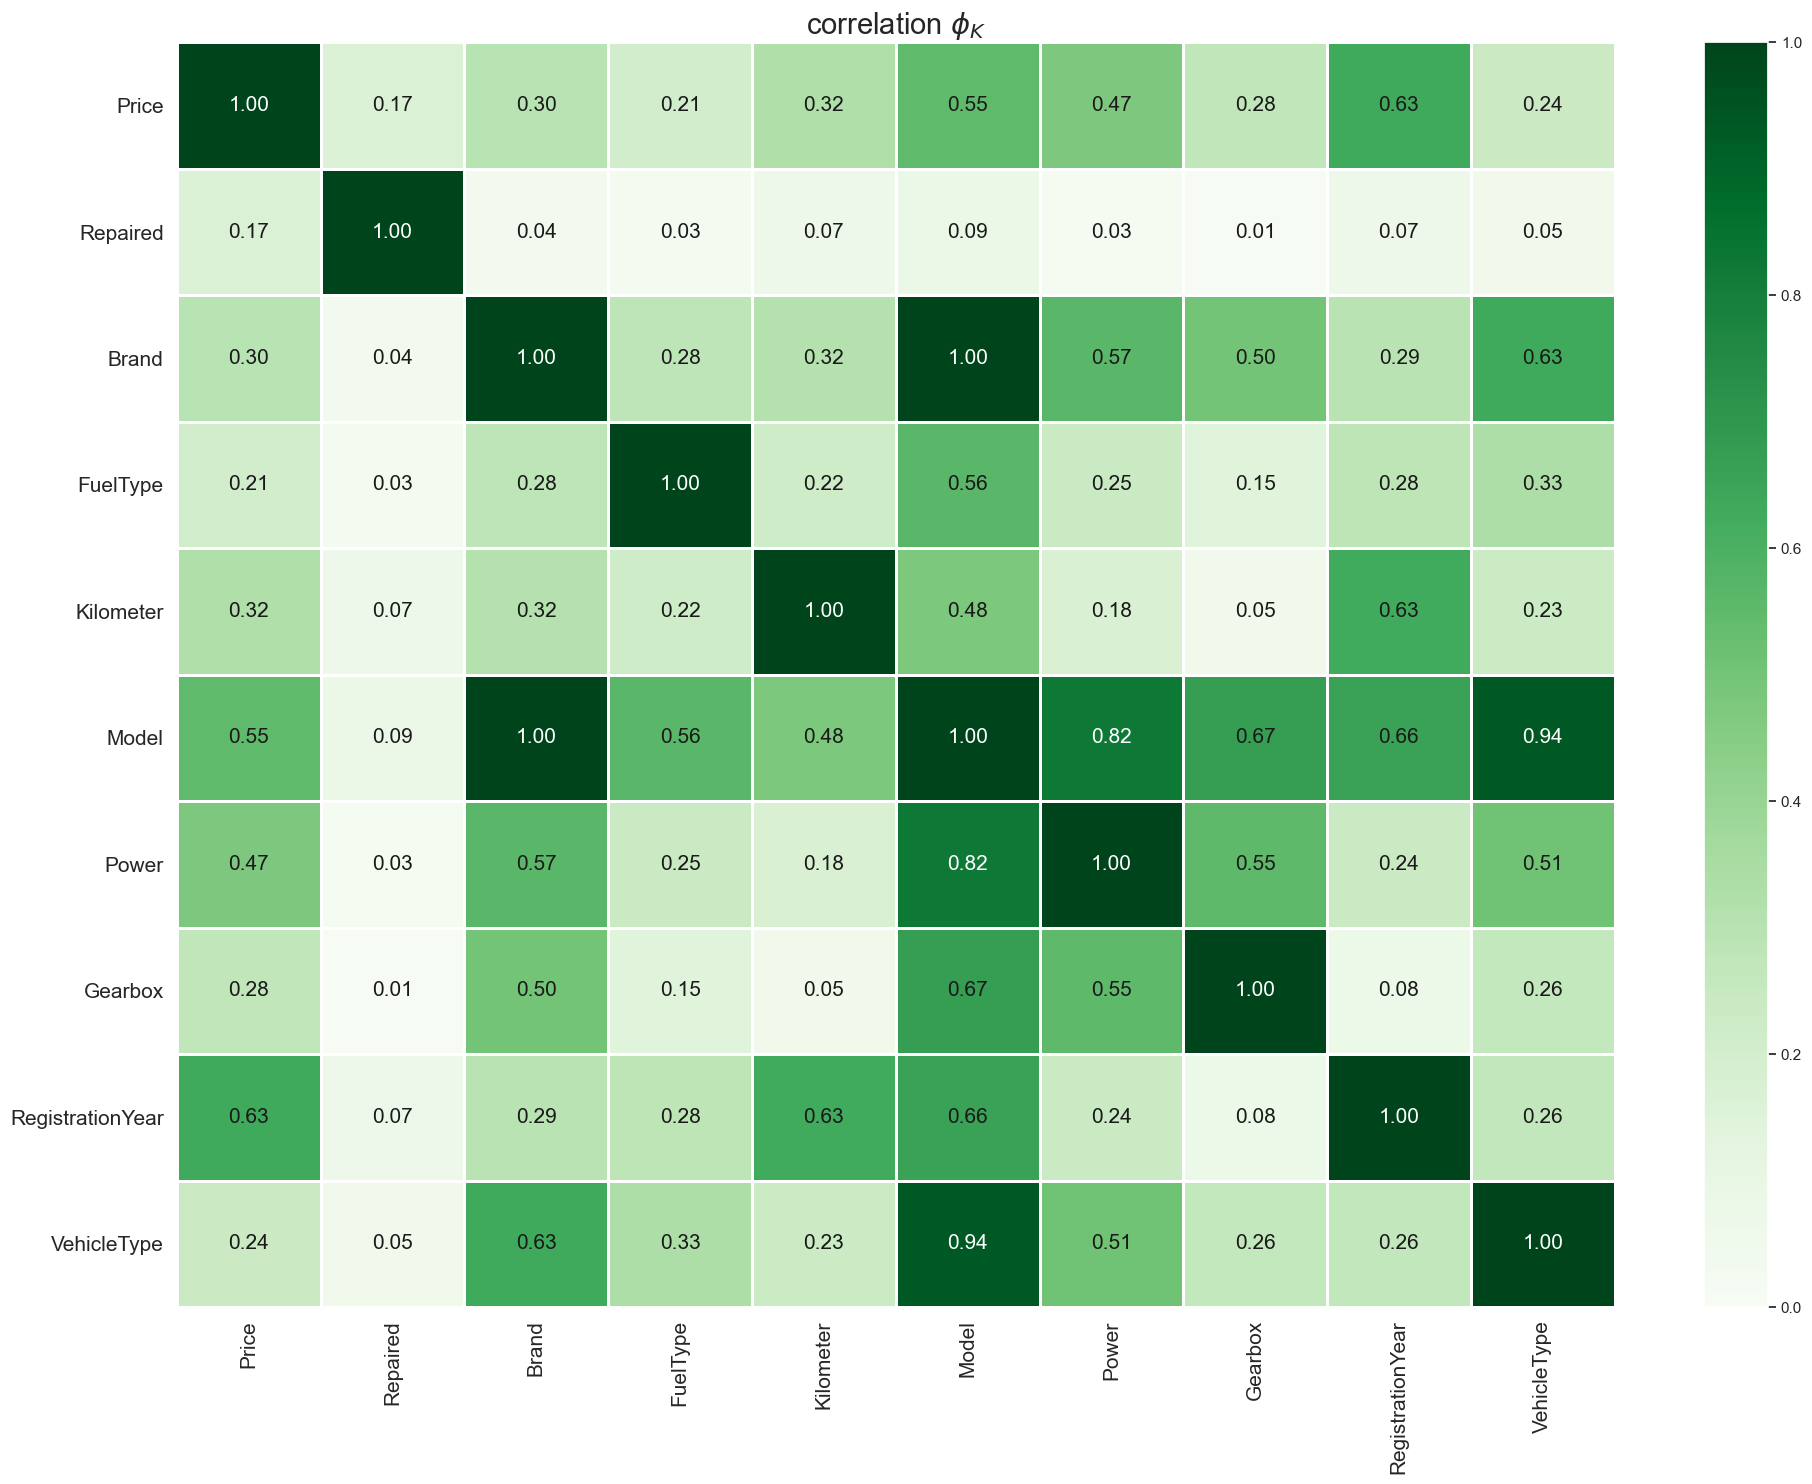

In [24]:
phik_overview = phik_matrix(df_train, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Наибольшую корреляцию с Price имеет год регистрации 0.63, модель 0.55 и мощность 0.47.

In [25]:
df_train.duplicated().sum()

24373

В данных 24373 дубля. Они не добавляют полезной информации и увеличивают время на обучение. удалим их.

In [26]:
df_train = df_train.drop_duplicates()

## Обучение моделей

Данные уже разбиты на тренировочную и тестовую выборки, приступим к созданию пайплайна.

In [27]:
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'Kilometer', 'RegistrationYear']
num_cols = ['Power']

In [28]:
X_train = df_train.drop('Price', axis=1)
y_train = df_train['Price']

In [29]:
ord_pipe = Pipeline(
    [
        ('simpleImputere_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputere_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]
)

In [30]:
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, cat_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

In [31]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
) 

### Модель DecisionTreeRegressor

In [32]:
param_distributions = {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']  
}

In [33]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions,
    cv=4,
    scoring="neg_mean_squared_error",
    n_jobs = -1,
    random_state=RANDOM_STATE
)

In [34]:
time_models = {}

start = time()

randomized_search.fit(X_train, y_train)

end = time()
time_models['DecisionTreeRegressor'] = end - start

Посчитаем RMSE лучшей модели на кросс-валидации.

In [35]:
np.sqrt(-randomized_search.best_score_)

1947.0261786909948

На тесте RMSE показала значение равное 1947. Возьмем его как за базовое и посмотрим, сможем ли улучшить метрику с помощью других моделей.

### Модель Catboost

In [36]:
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)

In [37]:
params = {'eval_metric':"RMSE",
            'loss_function':'RMSE',
            'learning_rate':0.1,
            'random_state':RANDOM_STATE, 
            'verbose':100,
            'iterations':1000}

In [38]:
start = time()

cv_df = cv(params=params,
           pool=train_pool, 
           fold_count=4,
           shuffle=True,
           partition_random_seed=RANDOM_STATE)

end = time()
time_models['CatBoost'] = end - start

Training on fold [0/4]
0:	learn: 6838.4034414	test: 6813.8749156	best: 6813.8749156 (0)	total: 101ms	remaining: 1m 40s
100:	learn: 1688.0220584	test: 1656.2815564	best: 1656.2815564 (100)	total: 2.77s	remaining: 24.7s
200:	learn: 1620.2968656	test: 1598.1851237	best: 1598.1851237 (200)	total: 7.05s	remaining: 28s
300:	learn: 1587.6817583	test: 1574.8877505	best: 1574.8877505 (300)	total: 11s	remaining: 25.5s
400:	learn: 1566.3172375	test: 1560.8488129	best: 1560.8488129 (400)	total: 13.7s	remaining: 20.5s
500:	learn: 1549.0484516	test: 1550.8035725	best: 1550.8035725 (500)	total: 16.6s	remaining: 16.6s
600:	learn: 1534.2881652	test: 1543.4975494	best: 1543.4975494 (600)	total: 19.7s	remaining: 13.1s
700:	learn: 1523.4642657	test: 1538.3917874	best: 1538.3917874 (700)	total: 22.6s	remaining: 9.64s
800:	learn: 1514.5742957	test: 1534.4377531	best: 1534.4377531 (800)	total: 25.8s	remaining: 6.41s
900:	learn: 1505.0529169	test: 1530.6347254	best: 1530.6347254 (900)	total: 28.8s	remaining: 

In [39]:
cv_df.sort_values('test-RMSE-mean').head(1)

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
999,999,1550.75816,15.57919,1490.293661,4.710086


Модель catboost на кросс-валидации дала среднее RMSE 1551.

### Модель LightGBM

In [40]:
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

train_data = lgb.Dataset(X_train, label=y_train)

In [41]:
params_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'random_state': RANDOM_STATE
    }

In [42]:
num_round = 1000
start = time()
bst = lgb.cv(params_lgb, train_data, num_round, nfold=4)
end = time()
time_models['LightGBM'] = end - start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 109891, number of used features: 9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 109891, number of used features: 9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data poin

In [43]:
pd.DataFrame(bst).sort_values('valid rmse-mean').head(1)

,valid rmse-mean,valid rmse-stdv
981,1514.748118,10.259363


Модель lgb на кросс-валидации дала среднее RMSE 1515, что является лучшим результатом.

## Анализ моделей

Выведем время фактически затраченное на обучение.

In [44]:
time_models

{'DecisionTreeRegressor': 10.192824840545654,
 'CatBoost': 127.70960903167725,
 'LightGBM': 14.143428087234497}

Итак, в данном исследовании были разработаны модели машинного обучения на основе:
1. DecisionTreeRegressor;
2. Catboost с отфильтрованными и исходными данными;
3. LightGBM. 


Самой точной моделью является LightGBM, а самой быстрой DecisionTreeRegressor. Так как метрика RMSE у LightGBM значительно выше, а время у лучших моделей примерно сопоставимо, выигрышной считается LightGBM. 

Но если заказчик посчитает время более приоритетной метрикой, так как RMSE у DecisionTreeRegressor также попадает под критерий успеха до 2500, можно заменить модель.

В шаге предобработки данных лучшим решением является не заполнять пропущенные значения, а удалить их вовсе. Этот вывод можно сделать на основании метрики RMSE у LightGBM по заполнении данных в 1515, а при полном удалении пропусков 1392.

Выбрав лучшей моделью LightGBM, воспроизведем ее и используем ее на тестовых данных.

Заполним пропуски в тестовых данных.

In [45]:
df_test['Repaired'] = df_test['Repaired'].fillna('no')

for col in ['VehicleType', 'Gearbox', 'FuelType']:
    df_test[col] = df_test.groupby('Model')[col].transform(
        lambda x: x.fillna((x.mode()[0] if x.count()!=0 else "other")))
    
for col in cat_cols:
    df_test[col] = df_test[col].astype('category')

In [46]:
lgb_model = lgb.train(params_lgb, train_data, num_round)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 146522, number of used features: 9
[LightGBM] [Info] Start training from score 5918.740489


In [47]:
y_pred = lgb_model.predict(df_test.drop('Price', axis=1))

In [48]:
mean_squared_error(y_test, y_pred, squared=False)

1483.477422430789

RMSE на тестовых данных 1483.

## Вывод

В данном проекте была разработана модель машинного обучения для сервиса по продаже автомобилей с пробегом «Не бит, не крашен». Модель позволяет узнать быстро узнать рыночную стоимость автомобиля. Для этого были получены исторические данные об авто, которые содержали большое количество пропусков и аномальных значений.

В полученных данных было много аномалий и пропусков. После очистки из данных были удалены дубликаты.

Во время анализа данных, ф-корреляция с таргетом `Price` у признаков год регистрации 0.63, модель 0.55 и мощность 0.47. 

Для заказчика является важным время обучение. LightGBM на кросс-валидации фактически затратила 13 сек.

RMSE показал на тесте 1483, попадая под критерий успеха до 2500.